# Example use on mvtec dataset

#### Import padim_implementation module

In [1]:
import os
import sys
sys.path.append(os.path.abspath('../../'))
import padim_implementation as pi

#### Import dependencies

In [2]:
import torch
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt

#### Set device

In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')  # The training process requires quite a lot of RAM, so you might have to run it on the cpu
print("Device:", device)

Device: cpu


#### Choose a model to extract features from

In [4]:
features_model = pi.Resnet18Features(device)

#### If you do not want all the dimensions of the embedding vectors, choose the wanted indices

In [5]:
indices = pi.getOriginalResnet18Indicies(device)

## 
## Training

#### Load dataset

In [6]:
class_name = 'bottle'
data_path = '../../data/mvtec_dataset/' # Path to mvtec dataset
dataset = pi.MVTecDataset(data_path, class_name=class_name, is_train=True)
dataloader = DataLoader(dataset, batch_size=32, pin_memory=True)
print("Number of images in dataset:", len(dataset))

Number of images in dataset: 209


#### Extract the embedding vectors from the whole dataset

In [7]:
embedding_vectors = pi.extractEmbeddingVectorsDataloader(features_model, dataloader, device, indices=indices)
print("Shape of embedding vectors:", embedding_vectors.shape)

Feature extraction:   0%|          | 0/7 [00:00<?, ?it/s]/home/plejd/anaconda3/envs/vision/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Feature extraction: 100%|██████████| 7/7 [00:15<00:00,  2.20s/it]

Shape of embedding vectors: torch.Size([209, 100, 56, 56])


#### Calculate the means and the inverse of the covariance matrices for the embedding vectors

In [8]:
mean, cov_inv = pi.getMeanCov(embedding_vectors, device)

Calculating covariance:   3%|▎         | 100/3136 [00:00<00:03, 997.17it/s]

Calculating mean


Calculating covariance: 100%|██████████| 3136/3136 [00:03<00:00, 971.61it/s]


Calculating inverse of covariance


#### Save the distributions

In [9]:
distributions_path = '../distributions/'
torch.save(mean, distributions_path+'bottle_mean.pt')
torch.save(cov_inv, distributions_path+'bottle_cov_inv.pt')

## 
## Inference

In [6]:
distributions_path = '../distributions/'
mean = torch.load(distributions_path+'bottle_mean.pt').to(device)
cov_inv = torch.load(distributions_path+'bottle_cov_inv.pt').to(device)

#### Load images

In [12]:
paths = [
    '../../data/mvtec_dataset/bottle/test/broken_large/000.png',
#     '../../data/mvtec_dataset/bottle/test/broken_small/000.png',
#     '../../data/mvtec_dataset/bottle/test/contamination/000.png',
#     '../../data/mvtec_dataset/bottle/test/good/000.png',
#     '../../data/mvtec_dataset/bottle/test/good/001.png',
]
images = []
for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

#### Convert to batch

In [13]:
batch = pi.toBatch(images, device)
batch.shape

torch.Size([1, 3, 224, 224])

#### Calculate scores and classifications

In [14]:
patch_scores, image_scores, patch_classifications, image_classifications = pi.anomalyDetection(batch, features_model, mean, cov_inv, device, 9, indices=indices)
print("Image scores:", image_scores)
print("Image classifications:", image_classifications)

Image scores: tensor([19.6080])
Image classifications: tensor([0.])


#### Visualize result

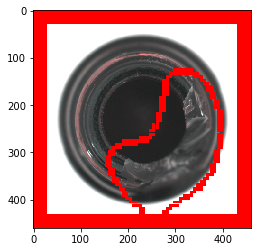

In [20]:
img = pi.getBoundaryImageClassificationGroup(images, patch_classifications, image_classifications, 400)
# img = pi.getBoundaryImageClassification(images[0], patch_classifications[0], image_classifications[0], 400)
plt.imshow(img)
plt.show()